# A/B-тестирование

**Цель исследования**   
Провести оценку результатов A/B-теста

**Техническое задание**
- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.
    
**Ход исследования**   
Иследование пройдет в шесть этапов:
* Обзор данных
* Предобработка данных
* Оценка корректности проведения теста
* Анализ данных
* Оценка результатов A/B-тестирования, проверка статистических гипотез
* Выводы и рекомендации

## Описание данных

**Входные данные**    
В нашем распоряжении датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.


## Обзор данных

In [118]:
# импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as mth
import datetime as dt
import scipy.stats as stats
import warnings
from scipy import stats as st
from plotly import graph_objects as go
from IPython.display import set_matplotlib_formats
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [119]:
# ограничение на количество столбцов
pd.set_option('display.max_columns', 50)

# ограничение на ширину столбцов
pd.set_option('display.max_colwidth', 120)

# игнорируем предупреждения
pd.set_option('chained_assignment', 'warn')
warnings.simplefilter(action='ignore', category=FutureWarning)

# выставляем ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

# устанавливаем стиль графиков
sns.set(rc={'figure.dpi':200, 'savefig.dpi':300})   
sns.set_context('notebook')

In [120]:
# чтение файлов с данными и сохранение в df

try:
    events, marketing_events, new_users, participants = (
        pd.read_csv('/datasets/final_ab_events.csv'),
        pd.read_csv('/datasets/ab_project_marketing_events.csv'),
        pd.read_csv('/datasets/final_ab_new_users.csv'), 
        pd.read_csv('/datasets/final_ab_participants.csv')
    )


except:
    events, marketing_events, new_users, participants = (
        pd.read_csv('final_ab_events.csv'),
        pd.read_csv('ab_project_marketing_events.csv'),
        pd.read_csv('final_ab_new_users.csv'), 
        pd.read_csv('final_ab_participants.csv')
    )

In [121]:
def info(data):

    display(data.head())
    display(data.info())
    display(data.describe())
    display('duplicates',data.duplicated().sum())
    display('missing',data.isna().sum())

### events

In [122]:
info(events)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

,details
count,"62,740.00"
mean,23.88
std,72.18
min,4.99
25%,4.99
50%,4.99
75%,9.99
max,499.99


'duplicates'

0

'missing'

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

In [123]:
events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [124]:
events['details'].unique()

array([ 99.99,   9.99,   4.99, 499.99,    nan])

Файл содержит данные о 440317 событиях (авторизация, просмотр страниц товара, просмотр корзины, покупка). Есть пропуски в столбце `details`(377577), но это нормально, т.к. он заполняется суммой оплаты только при совершении покупки. Суммы покупок - фиксированные (4,99 - 9,99 - 99,99 - 499,99).   
В этой таблице так же следует заменить тип данных столбца с данными о времени.

### marketing_events

In [125]:
info(marketing_events)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,International Women's Day Promo,APAC,2020-05-09,2020-02-07
freq,1,4,1,1


'duplicates'

0

'missing'

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

Согласно ТЗ:   
дата запуска теста: 2020-12-07;   
дата остановки набора новых пользователей: 2020-12-21;   
дата остановки теста: 2021-01-04.   

В период проведения теста проходила промоакция "Christmas&New Year Promo" (с 25 декабря по 3 января). Зто может повлиять на чистоту результатов тестирования.    
Т.к. данная таблица - справочная, никаких предобработок данных в ней делать не будем.

### new_users

In [126]:
info(new_users)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,DD5621F01D0F86DF,2020-12-21,EU,Android
freq,1,6290,46270,27520


'duplicates'

0

'missing'

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [127]:
new_users['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

In [128]:
new_users['device'].unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

Данные о 61733 уникальных пользователей из 4 регионов, которые используют 4 вида устройств. Дубликатов и пропусков нет.   
Отметим, что у столбца `first_date` необходимо заменить тип данных.

### participants

In [129]:
info(participants)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,81AA83FBC31B6C0B,A,interface_eu_test
freq,2,9655,11567


'duplicates'

0

'missing'

user_id    0
group      0
ab_test    0
dtype: int64

In [130]:
participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

Всего 18268 событий, 2 вида теста, дубликатов и пропусков нет.

## Предобработка данных

In [131]:
# меняем тип поля на datetime

new_users['first_date'] = pd.to_datetime(new_users['first_date'], format = '%Y-%m-%d')

In [132]:
# меняем тип поля на datetime

events['event_dt'] = pd.to_datetime(events['event_dt'], format = '%Y-%m-%d %H:%M:%S')

## Оценка корректности проведения теста

### Аудитория теста

In [134]:
print('Всего пользователей в логе %d.' % (new_users['user_id'].nunique()))
print('В среднем событий на пользователя %d.' % (events.shape[0] / new_users['user_id'].nunique()))

Всего пользователей в логе 61733.
В среднем событий на пользователя 7.


In [135]:
participants.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test                 group         
interface_eu_test       A         5831
                        B         5736
recommender_system_test A         3824
                        B         2877

Логи содержат данные о двух тестированиях: помимо нашего тестирования (внедрение улучшеной рекомендательной системы) проводилось крупное исследование по результатам изменения интерфейса.

Посмотрим, сколько пользователей участвовало в обоих тестированиях.

In [136]:
both_tests = (participants.groupby('user_id')
    .agg({'ab_test': 'nunique'})
    .reset_index()
    .query('ab_test > 1'))
both_tests.shape[0]

1602

Количество пользователей, участвующих в обоих тестрованиях - 1602 человека

In [137]:
# выделяем пользователей, попавших в оба теста, в отдельный датафрейм
participants_new = participants[participants['user_id'].isin(both_tests['user_id'].values)]

participants_new.head(6)

,user_id,group,ab_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
10,B3A2485649E4A012,A,recommender_system_test
25,EAFB9027A27D510C,B,recommender_system_test
29,5D5E6EE92AF6E9E0,B,recommender_system_test
31,D6E62099519F986C,A,recommender_system_test


Теперь поближе познакомимся с пользователями, которые участвовали в группе В параллельного теста (ведь именно они видели изменения). Как эти пользователи распределены между группами нашего теста? Если они распределены равномерно, то мы можем предположить, что конкурирующий тест оказывал одинаковое влияние на группы А и В, и таких пользователей можно оставить.

In [138]:
participants_B =  participants_new.query('ab_test == "interface_eu_test" & group =="B"')
participants_B.shape[0]

783

Количество пользователей группы В параллельного теста - 783 человека

In [139]:
# выделяеи пользователей, участвующих в обоих тестах, в отдельный датафрейм
participants_new_B = participants[participants['user_id'].isin(participants_B['user_id'].values)]

# оставляем среди них пользователей только нашего теста:
participants_new_B = participants_new_B.query('ab_test == "recommender_system_test"')

participants_new_B.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test                 group         
recommender_system_test A          439
                        B          344

Мы видим, как участники группы В конкурирующего теста (из тех, кто участвовал в обоих тестах) распределились по тестовым группам нашего эксперимента.

<p>Проведем z-test и проверим гипотезу о равенстве пропорций пользователей из группы В теста-конкурента в группе А и группе В нашего теста:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{доли уникальных посетителей одинаковы}\\
   H_1 :\text{доли уникальных посетителей отличаются}
 \end{cases}
\end{equation*}$

In [140]:
alpha = 0.05  # критический уровень статистической значимости

purchases = np.array([439, 344])
leads = np.array([3824, 2877])

# пропорция успехов в первой группе:
p1 = purchases[0]/leads[0]

# пропорция успехов во второй группе:
p2 = purchases[1]/leads[1]

# пропорция успехов в комбинированном датасете:
p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])

# разница пропорций в датасетах
difference = p1 - p2 

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )


p-значение:  0.5475925169519402
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Заключаем, что пользователи, участвующие в двух тестах, распределены по нашим группам равномерно.

Тем не менее, для исключения влияния пользователей группы В конкурирующего теста, удаляем их из участников нашего экспеимента.

In [141]:
participants = participants[~participants['user_id'].isin(participants_B['user_id'].values)].query('ab_test == "recommender_system_test"')
participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test
6697,9D263B8EF15CF188,B,recommender_system_test
6698,F2FBBA33F37DEC46,A,recommender_system_test
6699,29C92313A98B1176,B,recommender_system_test


оставляем пользователей только нашего теста

In [142]:
participants.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test                 group         
recommender_system_test A         3385
                        B         2533

В тесте участвует 5918 уникальных пользователей,количество участников распределено по группам неравномерно; 
проверим, что участники не попадают одновременно в группу А и В.

In [143]:
participants.groupby('user_id').agg({'group':'nunique'}).reset_index().query('group > 1')

,user_id,group


Таких участников нет. 

Так же, мы уберем все, что не соответствует заявленным в ТЗ датам: новые участники, зарегистрированные позже 21 декабря 2020 года и их действия, а так же все события, которые старше 2-х недель с момента регистрации участников.

In [180]:
display(new_users.query('first_date > "2020-12-21 23:59:59"'))

new_users_filtered = new_users.query('first_date <= "2020-12-21 23:59:59"')
print('Набор пользователей с %s по % s'% (new_users['first_date'].min(), new_users['first_date'].max()))

,user_id,first_date,region,device
23821,5815F7ECE74D949F,2020-12-22,CIS,PC
23822,32EAEA5E903E3BC1,2020-12-22,N.America,Android
23823,9DF7A3C46487EF0B,2020-12-22,EU,Android
23824,ADE98C6440423287,2020-12-22,EU,iPhone
23825,5A5833D3AEA75255,2020-12-22,N.America,PC
...,...,...,...,...
33290,165AFCBF42C043F8,2020-12-23,EU,PC
33291,54E7F36C0E976E24,2020-12-23,EU,Android
33292,7E43EB2E03A33E78,2020-12-23,EU,PC
33293,B8B679DEE9F2CA06,2020-12-23,EU,PC


Набор пользователей с 2020-12-07 00:00:00 по 2020-12-23 00:00:00


In [145]:
new_users.groupby('region').agg({'user_id': 'nunique'})

,user_id
region,
APAC,3153
CIS,3155
EU,46270
N.America,9155


In [146]:
# добавим информацию в таблицу events_new:
events_new = events.merge(participants, on = 'user_id')
events_new = events_new.merge(new_users_filtered, on = 'user_id')

In [147]:
events_new

,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,recommender_system_test,2020-12-07,EU,Android
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,A,recommender_system_test,2020-12-07,EU,Android
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,Android
3,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,Android
4,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,Android
...,...,...,...,...,...,...,...,...,...
21837,1E6B9298415AA97A,2020-12-22 03:22:34,login,NaN,B,recommender_system_test,2020-12-21,N.America,Android
21838,1E6B9298415AA97A,2020-12-23 11:34:53,login,NaN,B,recommender_system_test,2020-12-21,N.America,Android
21839,1E6B9298415AA97A,2020-12-24 18:45:58,login,NaN,B,recommender_system_test,2020-12-21,N.America,Android
21840,1E6B9298415AA97A,2020-12-25 16:40:01,login,NaN,B,recommender_system_test,2020-12-21,N.America,Android


In [148]:
events_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21842 entries, 0 to 21841
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     21842 non-null  object        
 1   event_dt    21842 non-null  datetime64[ns]
 2   event_name  21842 non-null  object        
 3   details     2939 non-null   float64       
 4   group       21842 non-null  object        
 5   ab_test     21842 non-null  object        
 6   first_date  21842 non-null  datetime64[ns]
 7   region      21842 non-null  object        
 8   device      21842 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 1.7+ MB


In [149]:
# подсчитаем разницу в днях между регистрацией и событием
events_new['diff'] = events_new['event_dt'] - events_new['first_date']

# уберем все, что находится за границей 14 дней с момента регистрации
events_new = events_new[events_new['diff'] <= "14 days 00:00:00"]
events_new

,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device,diff
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,recommender_system_test,2020-12-07,EU,Android,0 days 06:50:29
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,A,recommender_system_test,2020-12-07,EU,Android,2 days 02:19:17
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,Android,0 days 06:50:30
3,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,Android,1 days 10:52:27
4,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,Android,2 days 02:19:17
...,...,...,...,...,...,...,...,...,...,...
21837,1E6B9298415AA97A,2020-12-22 03:22:34,login,NaN,B,recommender_system_test,2020-12-21,N.America,Android,1 days 03:22:34
21838,1E6B9298415AA97A,2020-12-23 11:34:53,login,NaN,B,recommender_system_test,2020-12-21,N.America,Android,2 days 11:34:53
21839,1E6B9298415AA97A,2020-12-24 18:45:58,login,NaN,B,recommender_system_test,2020-12-21,N.America,Android,3 days 18:45:58
21840,1E6B9298415AA97A,2020-12-25 16:40:01,login,NaN,B,recommender_system_test,2020-12-21,N.America,Android,4 days 16:40:01


Итак, проверяем, что у нас получилось в итоге:

In [150]:
new_users_filtered['user_id'].nunique()

56470

Количество участников теста - 56470

In [151]:
participants.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test                 group         
recommender_system_test A         3385
                        B         2533

In [152]:
events_new['user_id'].nunique()

3244

Количество уникальных пользователей, совершавших действия в системе - 3244 человек

In [153]:
#разделение по группам
events_new.groupby('group').agg(users = ('user_id', 'nunique')).reset_index()

,group,users
0,A,2422
1,B,822


Как видим, у нас есть 2674 пользователя из 5918 уникальных участников , которые не совершали действий в системе после регистрации (это более 45%).

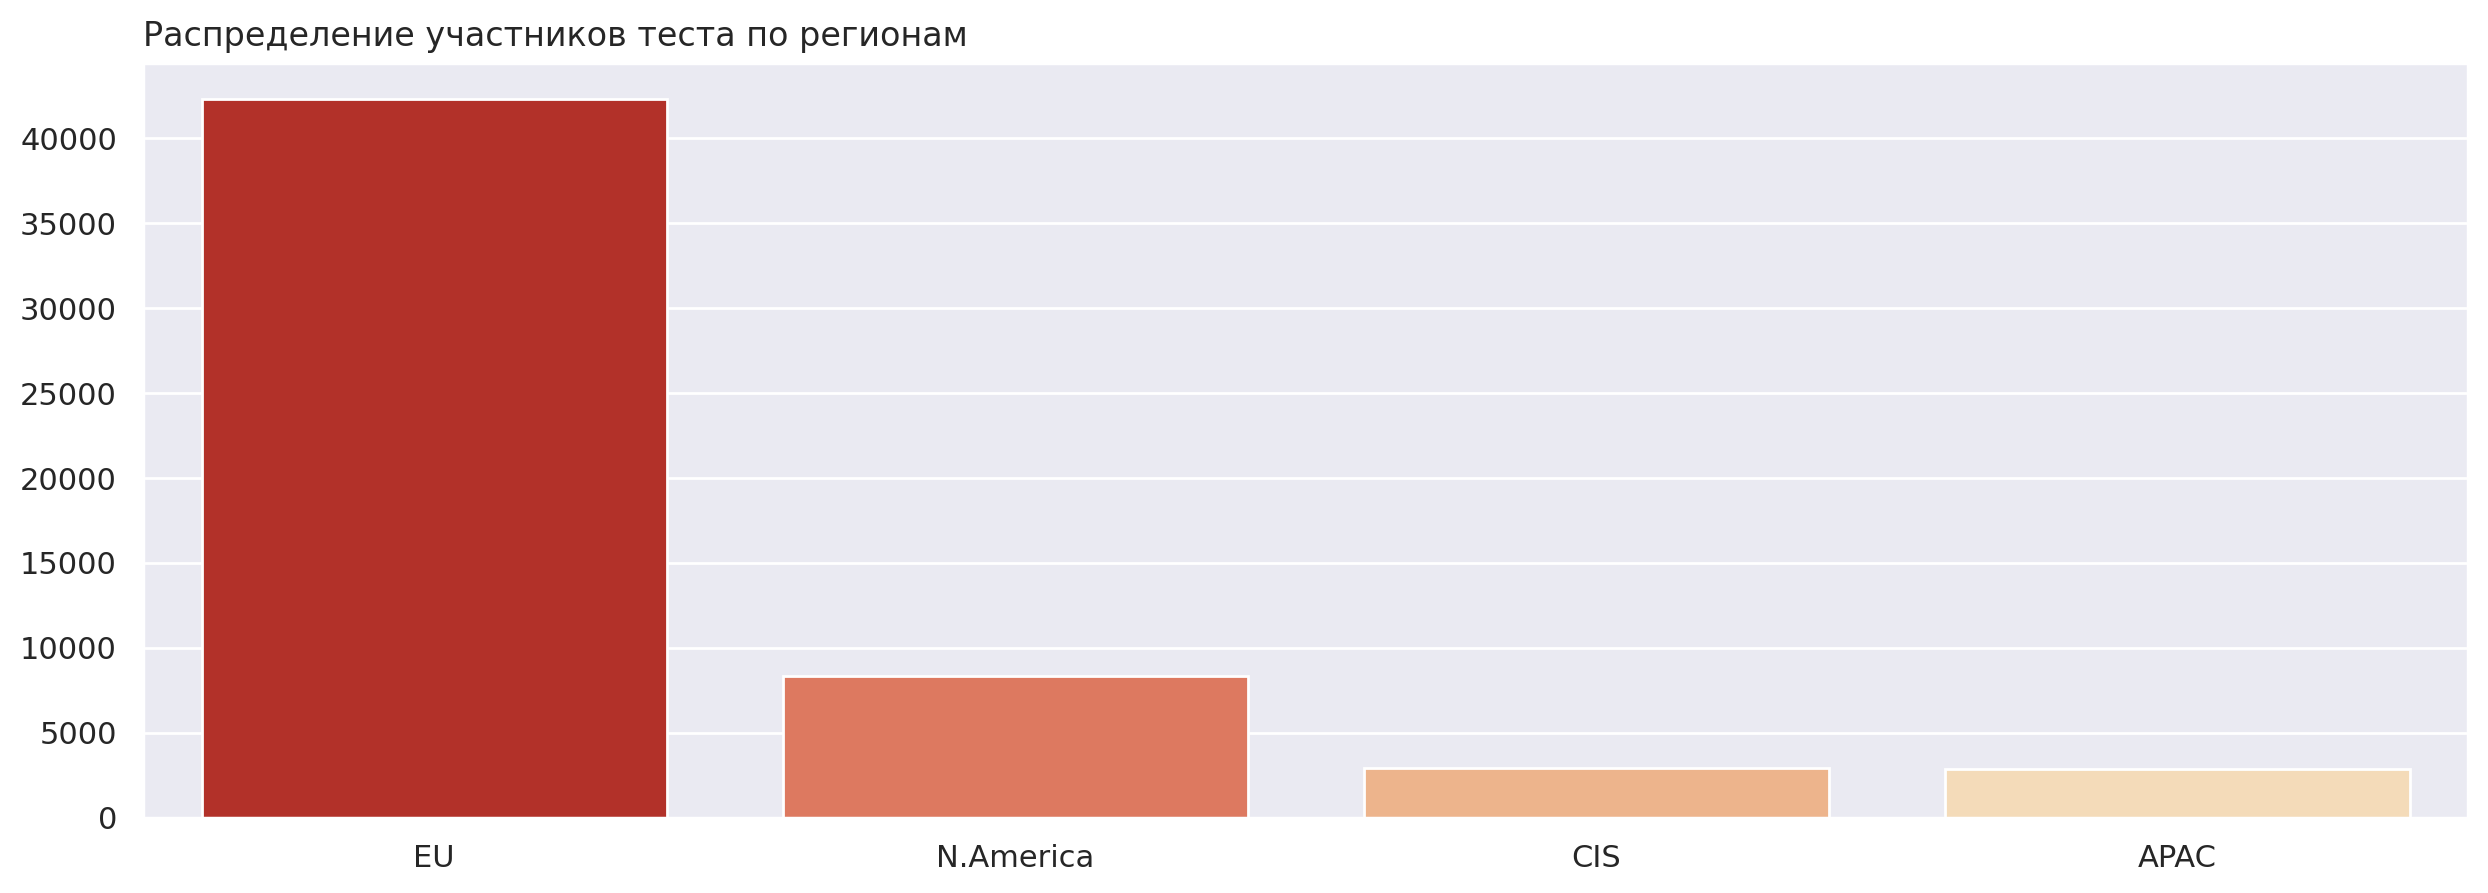

In [154]:
plt.figure(figsize=(15, 5))
plt.title('Распределение участников теста по регионам', loc='left')
sns.countplot(x = new_users_filtered['region'], 
    order = new_users_filtered['region'].value_counts().index, 
    palette='OrRd_r')

plt.xlabel('')
plt.ylabel('')
plt.show()

Есть небольшая доля пользователей, не принадлежащих региону EU. Ничего делать с ними не будем, т.к. возможна работа через VPN или пользователи могли находится в роуминге (например, уехали в отпуск).



Но, на всякий случай проведем анализ аудитории теста. Согласно ТЗ доля участников нашего теста из EU относительно всех новых пользователей из EU должна быть равна 15%.

In [155]:
eu_users = new_users_filtered[new_users_filtered['region'] == 'EU']['user_id'].nunique()
test_users = participants['user_id'].nunique()
print('Доля пользователей из EU - участников теста: {:.2%}'.format(test_users / eu_users))

Доля пользователей из EU - участников теста: 13.98%


### Время проведения теста

In [178]:
print('Данные о событиях с %s по %s' % (events['event_dt'].min(), events['event_dt'].max()))
print('Набор пользователей с %s по % s'% (new_users_filtered['first_date'].min(), new_users_filtered['first_date'].max()))

Данные о событиях с 2020-12-07 00:00:33 по 2020-12-30 23:36:33
Набор пользователей с 2020-12-07 00:00:00 по 2020-12-21 00:00:00


Как мы уже писали ранее: после набора пользователей, но до остановки теста, в период с 25.12.2020 по 03.01.2021гг. в EU проводилась акция "Christmas&New Year Promo", которая могла повлиять на исследуемые метрики.

* дата остановки набора новых пользователей после фильтрации соответствует ТЗ, то есть 2020-12-21;
* последнее событие теста по логам случилась в 2020-12-30 23:36:33, а по техническому заданию тест должен был продолжаться по 2021-01-04;

### Промежуточные выводы

Тест был проведён **с нарушениями**:

* После набора пользователей, но до остановки теста, в период с 25.12.2020 по 03.01.2021 в EU проводилась акция "Christmas&New Year Promo".
* В выгрузке нет данных о событиях с 31.12.2020 по 04.01.2021 (время остановки теста). Не хватает информации за 5 дней.
* Параллельно с нашим тестом шёл другой. После дополнительной проверки мы пришли к выводу, что это не повлияло на результаты нашего тестирования. Т.о. пользователи, которые параллельно участвовали в двух тестрованиях не искллючались из исследования.   
* Количество участников в группах А и В сильно различается (3385 и 2533, соответственно).
* Почти 45% пользователей теста не совершили ни одного действия в системе. Активных пользователей в группе А оказалось почти в 3 раза больше, чем в группе В (2422 против 822).
* На графиках зафиксирован сезонный всплеск активности, связанный с Рождественскими и новогодними праздниками
* После удаления пользователей -  участников группы B теста-конкурента, количество новых пользователей из EU снизилось до 13,98% (вместо заявленных 15%); так же вместо 6000 ожидаемых участников имеем только 5918.

Всё вышеперечисленное серьезно искажает результаты тестирования.

## Анализ данных

### Проверка распределения количества событий на пользователя

In [158]:
events_new.groupby('group').agg(users = ('user_id', 'nunique')).reset_index()

,group,users
0,A,2422
1,B,822


In [159]:
events_new.groupby('group').agg(users = ('user_id', 'count')).reset_index()

,group,users
0,A,16692
1,B,4393


count   3,244.00
mean        6.50
std         3.73
min         1.00
25%         4.00
50%         6.00
75%         9.00
max        24.00
Name: event_count, dtype: float64

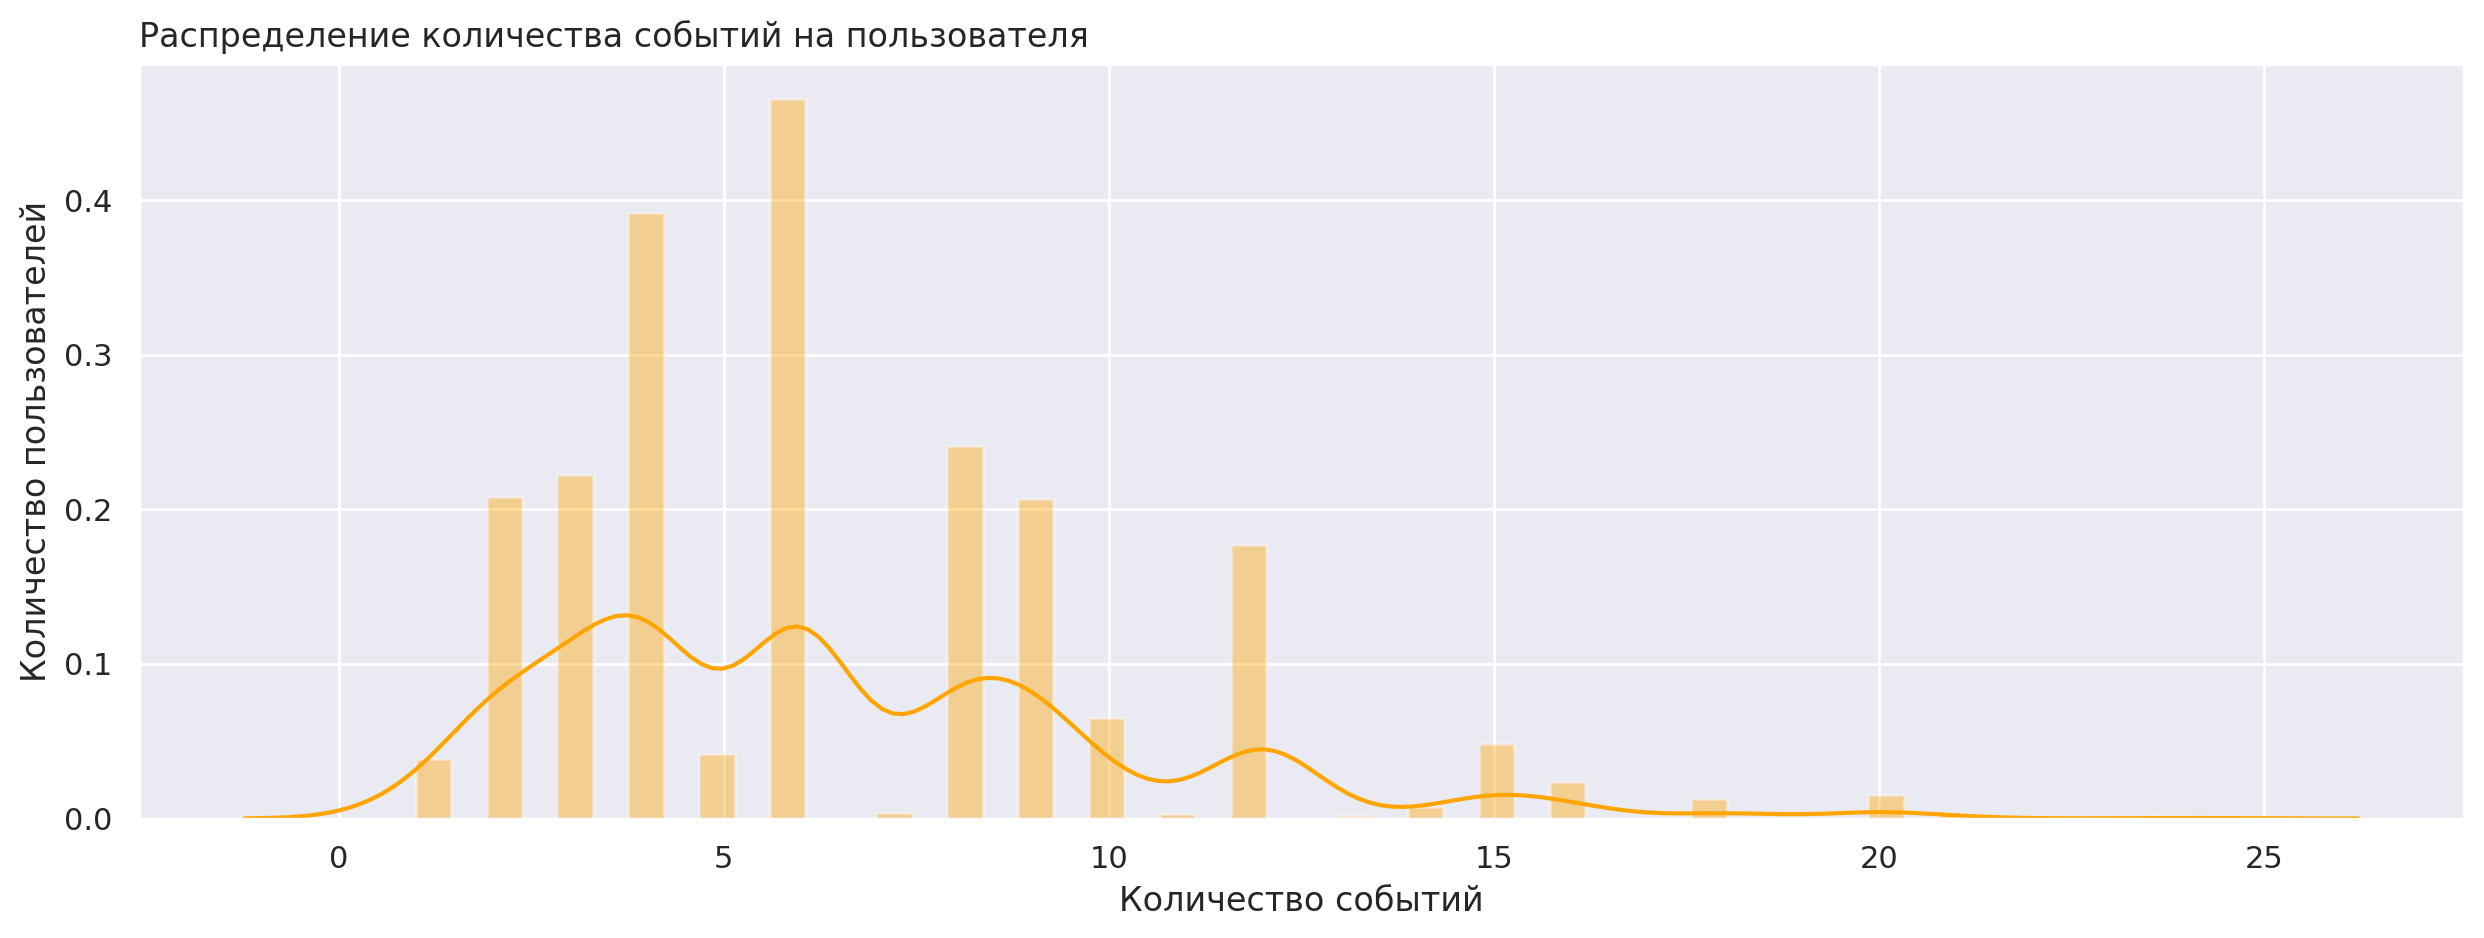

In [160]:
# посмотрим, сколько событий в среднем приходится на пользователя:
events_by_user = events_new.groupby('user_id').agg(event_count = ('event_name', 'count')).reset_index()

display(events_by_user['event_count'].describe())  

plt.figure(figsize=(15, 5))
plt.title('Распределение количества событий на пользователя', loc='left')
sns.distplot(events_by_user['event_count'], bins=50, color='orange')
plt.xlabel('Количество событий')                  
plt.ylabel('Количество пользователей')             
plt.show()

Итак, в среднем, на пользователя приходится порядка 6 событий. При этом, минимальное количество - всего одно, а максимальное - 24 шт. 

### Проверка распределения числа событий по дням

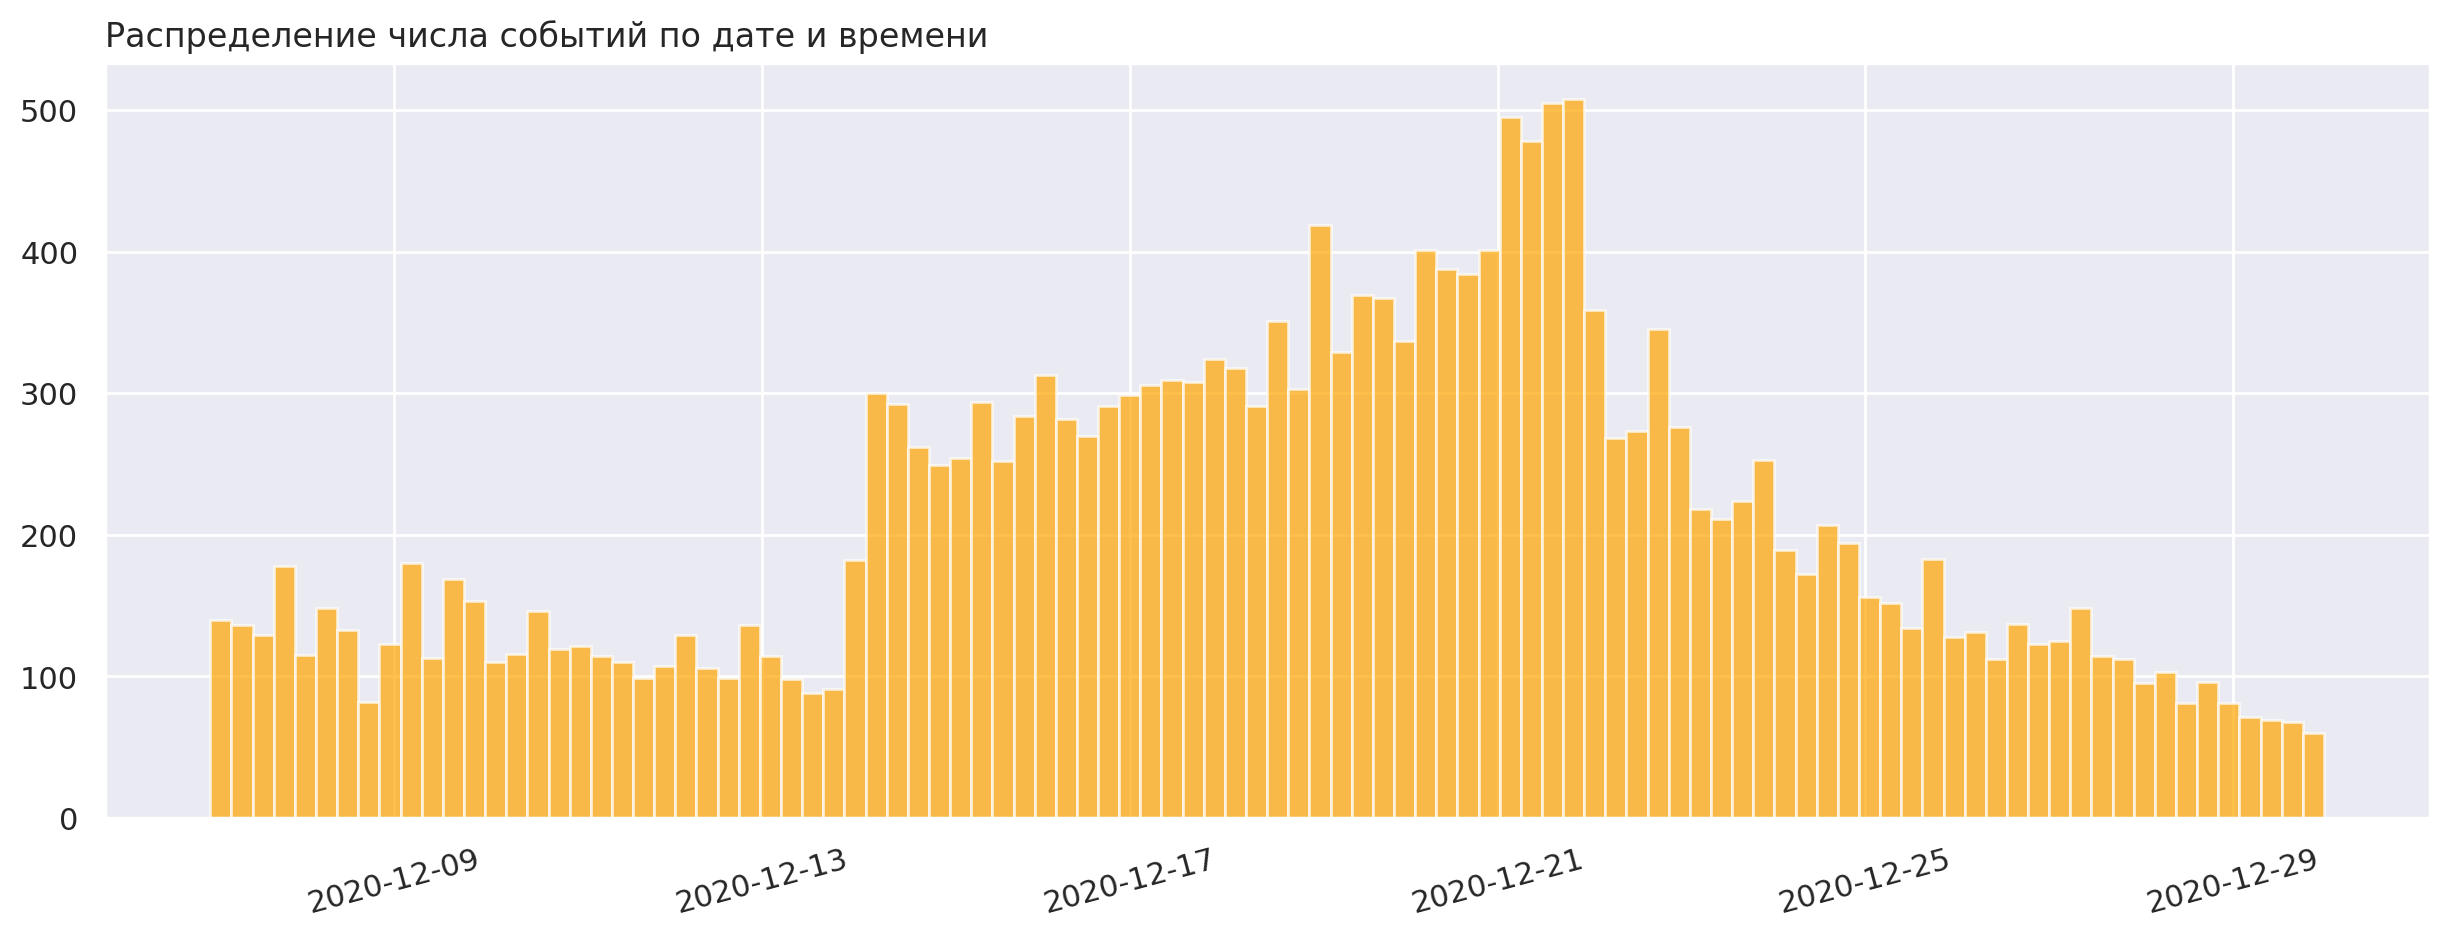

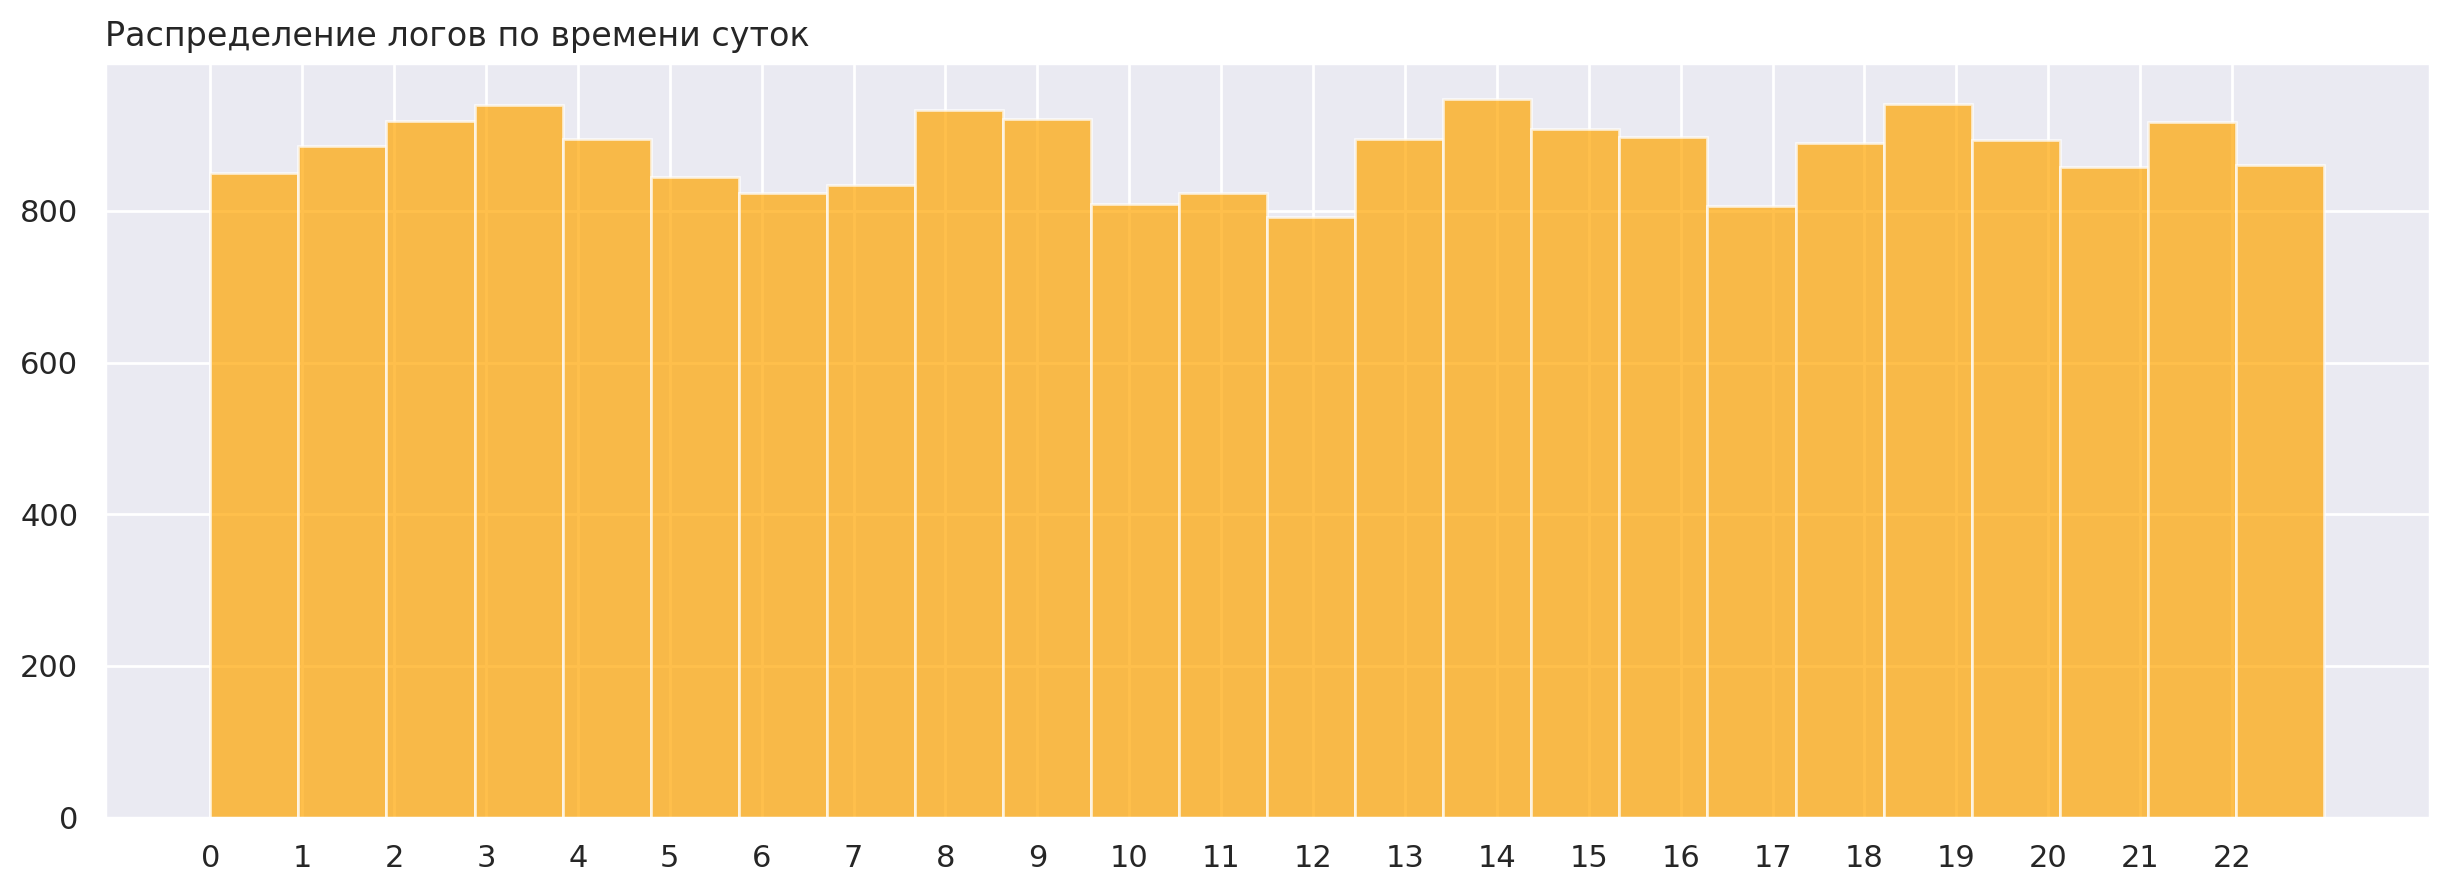

In [161]:
# гистограммы по дате и времени:

plt.title('Распределение числа событий по дате и времени', loc='left')
events_new['event_dt'].hist(bins=100, xrot=15,  figsize=(15, 5), alpha=0.7, color='orange')
plt.show()

plt.title('Распределение логов по времени суток', loc='left')
events_new['event_dt'].dt.hour.hist(bins=24, figsize=(15, 5), alpha=0.7, color='orange')
plt.xticks(range(0, 23))
plt.show()

Нибольший всплеск событий пришелся на период с 2020-12-14 по 2020-12-23. Т.е. мы еще имеем и сезонное влияние на тестовые данные - покупка подарков на Рождество. По времени суток особых различий нет.

### Оценка конверсии в воронке в выборках на разных этапах

Посмотрим, какие события есть в логах, как часто они встречаются.

In [162]:
events_all = (events_new.
    groupby('event_name').
    agg({'user_id': 'count'}).
    reset_index().
    rename(columns={'user_id' : 'total_events'}).
    sort_values(by='total_events', ascending=False))
events_all

,event_name,total_events
0,login,9545
2,product_page,5898
3,purchase,2848
1,product_cart,2794


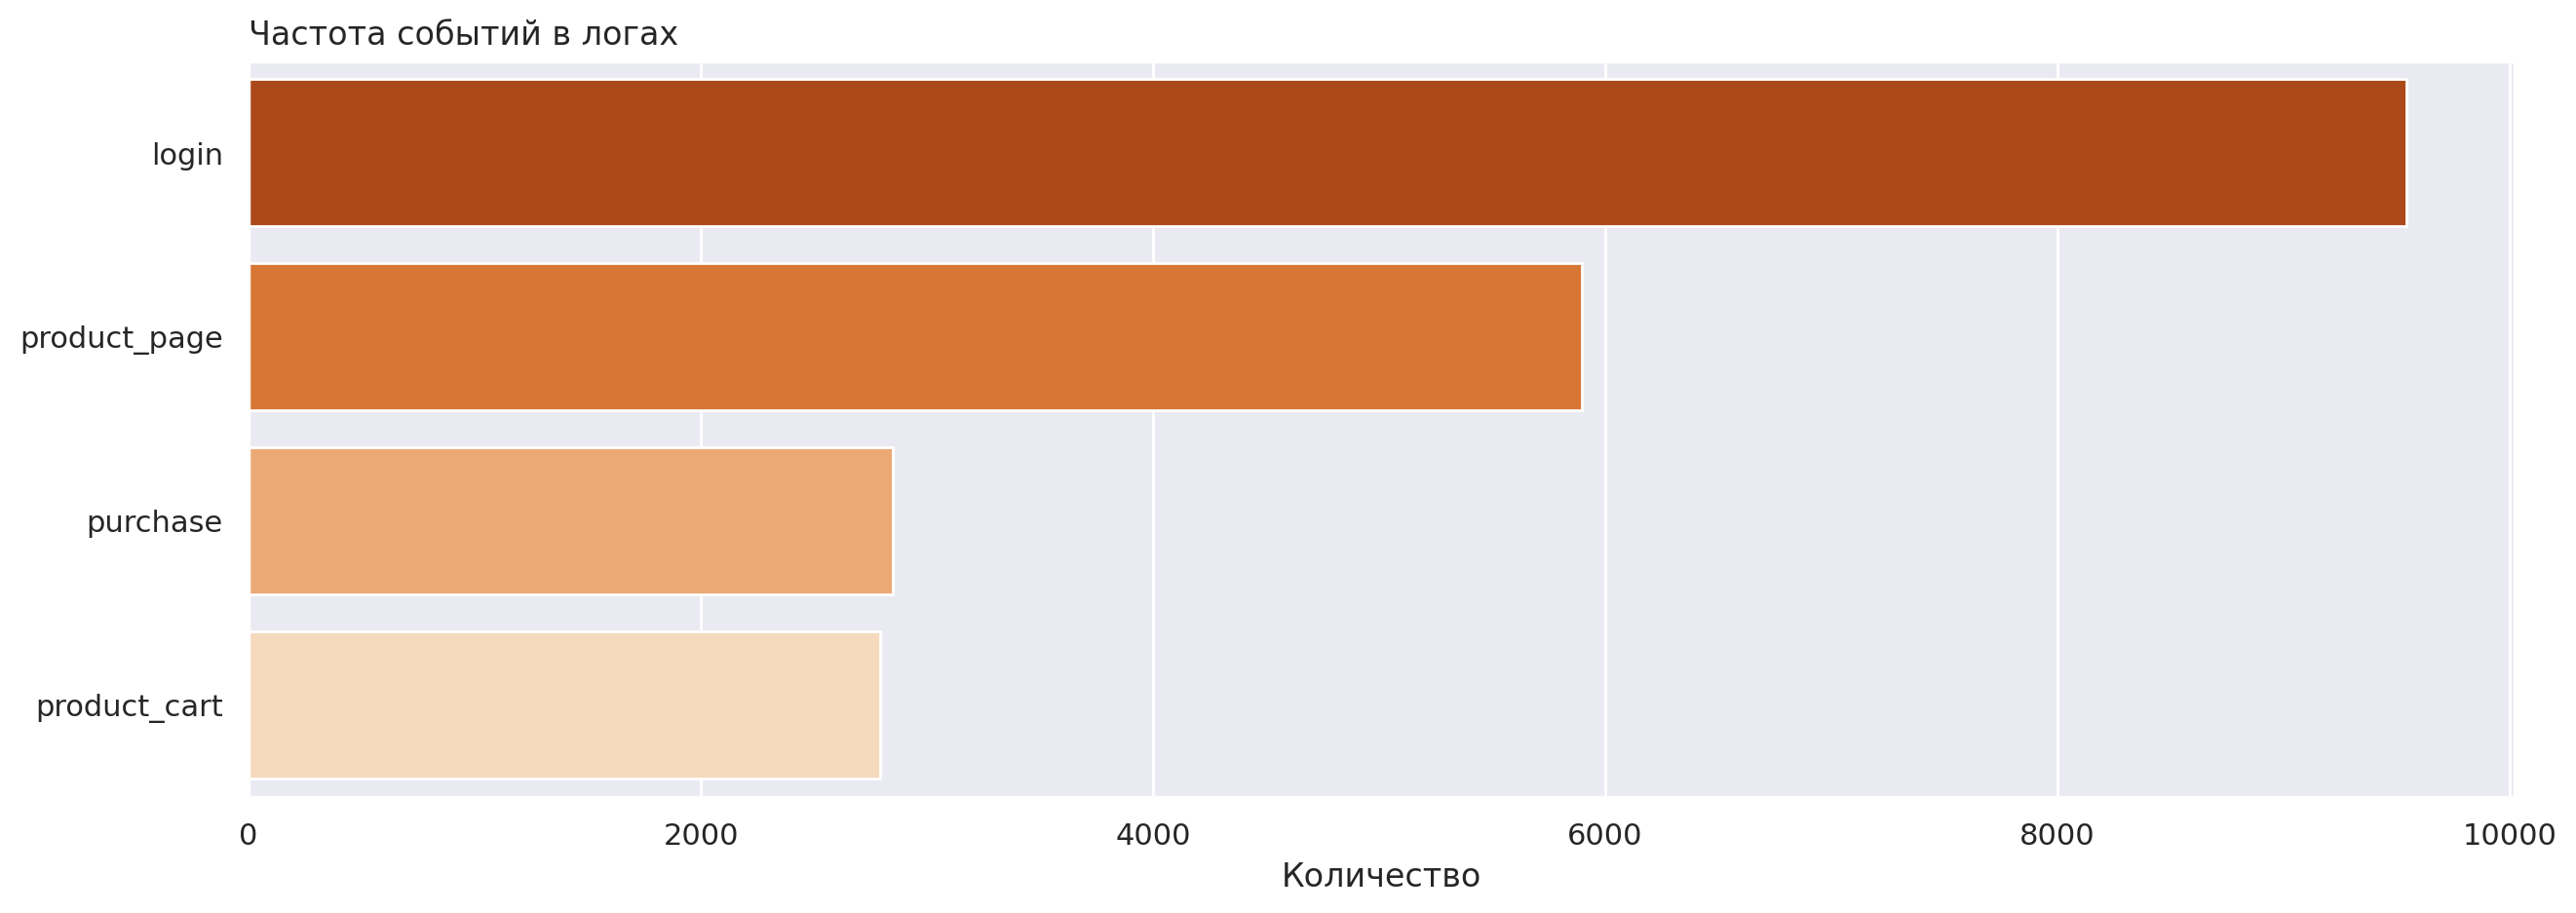

In [163]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='total_events', y='event_name', data=events_all, palette='Oranges_r', orient='h')
ax.set_title('Частота событий в логах', loc='Left')
ax.set_xlabel('Количество') 
ax.set_ylabel('') 
plt.show()

* login (авторизовались) сделали 9545 раз;    
* product_page (карточка товара) увидели 5898 раз;      
* product_card (корзина) увидели 2794 раза;     
* purchase (покупка) совершили 2848 раз.


Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [164]:
funnel = (events_new.
              groupby('event_name').
              agg({'user_id': 'nunique'}).
              reset_index().
              rename(columns={'user_id' : 'total_users'}).
              sort_values(by='total_users', ascending=False))
funnel['percent'] = funnel['total_users'] / events_new['user_id'].nunique() * 100  
funnel

,event_name,total_users,percent
0,login,3243,99.97
2,product_page,2030,62.58
3,purchase,999,30.80
1,product_cart,953,29.38


Ожидаемая последовательность событий `Авторизация` -> `Просмотр товара` -> `Просмотр корзины` -> `Покупка`. 

Чтобы графики отображались верно, добавим колонку с последовательность и отсортируем события по ней.

In [165]:
funnel['n'] = [1, 2, 4, 3]
funnel = funnel.sort_values(by='n')
funnel

,event_name,total_users,percent,n
0,login,3243,99.97,1
2,product_page,2030,62.58,2
1,product_cart,953,29.38,3
3,purchase,999,30.80,4


In [166]:
fig = go.Figure(go.Funnel(
    y = funnel['event_name'],
    x = funnel['total_users'],
    textposition = "inside",
    textinfo = "value+percent previous",
    opacity = 0.65,
    marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal"]})
    )

fig.update_layout(title_text='Воронка событий')
fig.show()

In [167]:
# считаем % по шагам (от предыдущего шага)  

users = events_new.pivot_table(
    index='user_id', 
    columns='event_name', 
    values='event_dt',
    aggfunc='min')

print('Авторизовались:', 
      '({:.1%})'.format(users['login'].count() / users['login'].count() ))
print('Просмотрели Карточку товара в % от предыдущего шага:', 
      '({:.1%})'.format(users['product_page'].count() / users['login'].count()))
print('Перешли в Корзину в % от предыдущего шага:', 
      '({:.1%})'.format(users['product_cart'].count() / users['product_page'].count()))
print('Оплатили в % от предыдущего шага:',
      '({:.1%})'.format(users['purchase'].count() / users['product_cart'].count()))

Авторизовались: (100.0%)
Просмотрели Карточку товара в % от предыдущего шага: (62.6%)
Перешли в Корзину в % от предыдущего шага: (46.9%)
Оплатили в % от предыдущего шага: (104.8%)


Мы видим, что наибольшее количество пользователей  теряется после первого шага (около 37%).    
Только 30% от первоначального количества пользователей успешно оплачивают товары из корзины.    

При этом, количество пользователей, оплативших покупки, больше, чем тех, кто перешел в Корзину. Видимо, имеется некий быстрый способ оплаты, например, с Карточки товара.

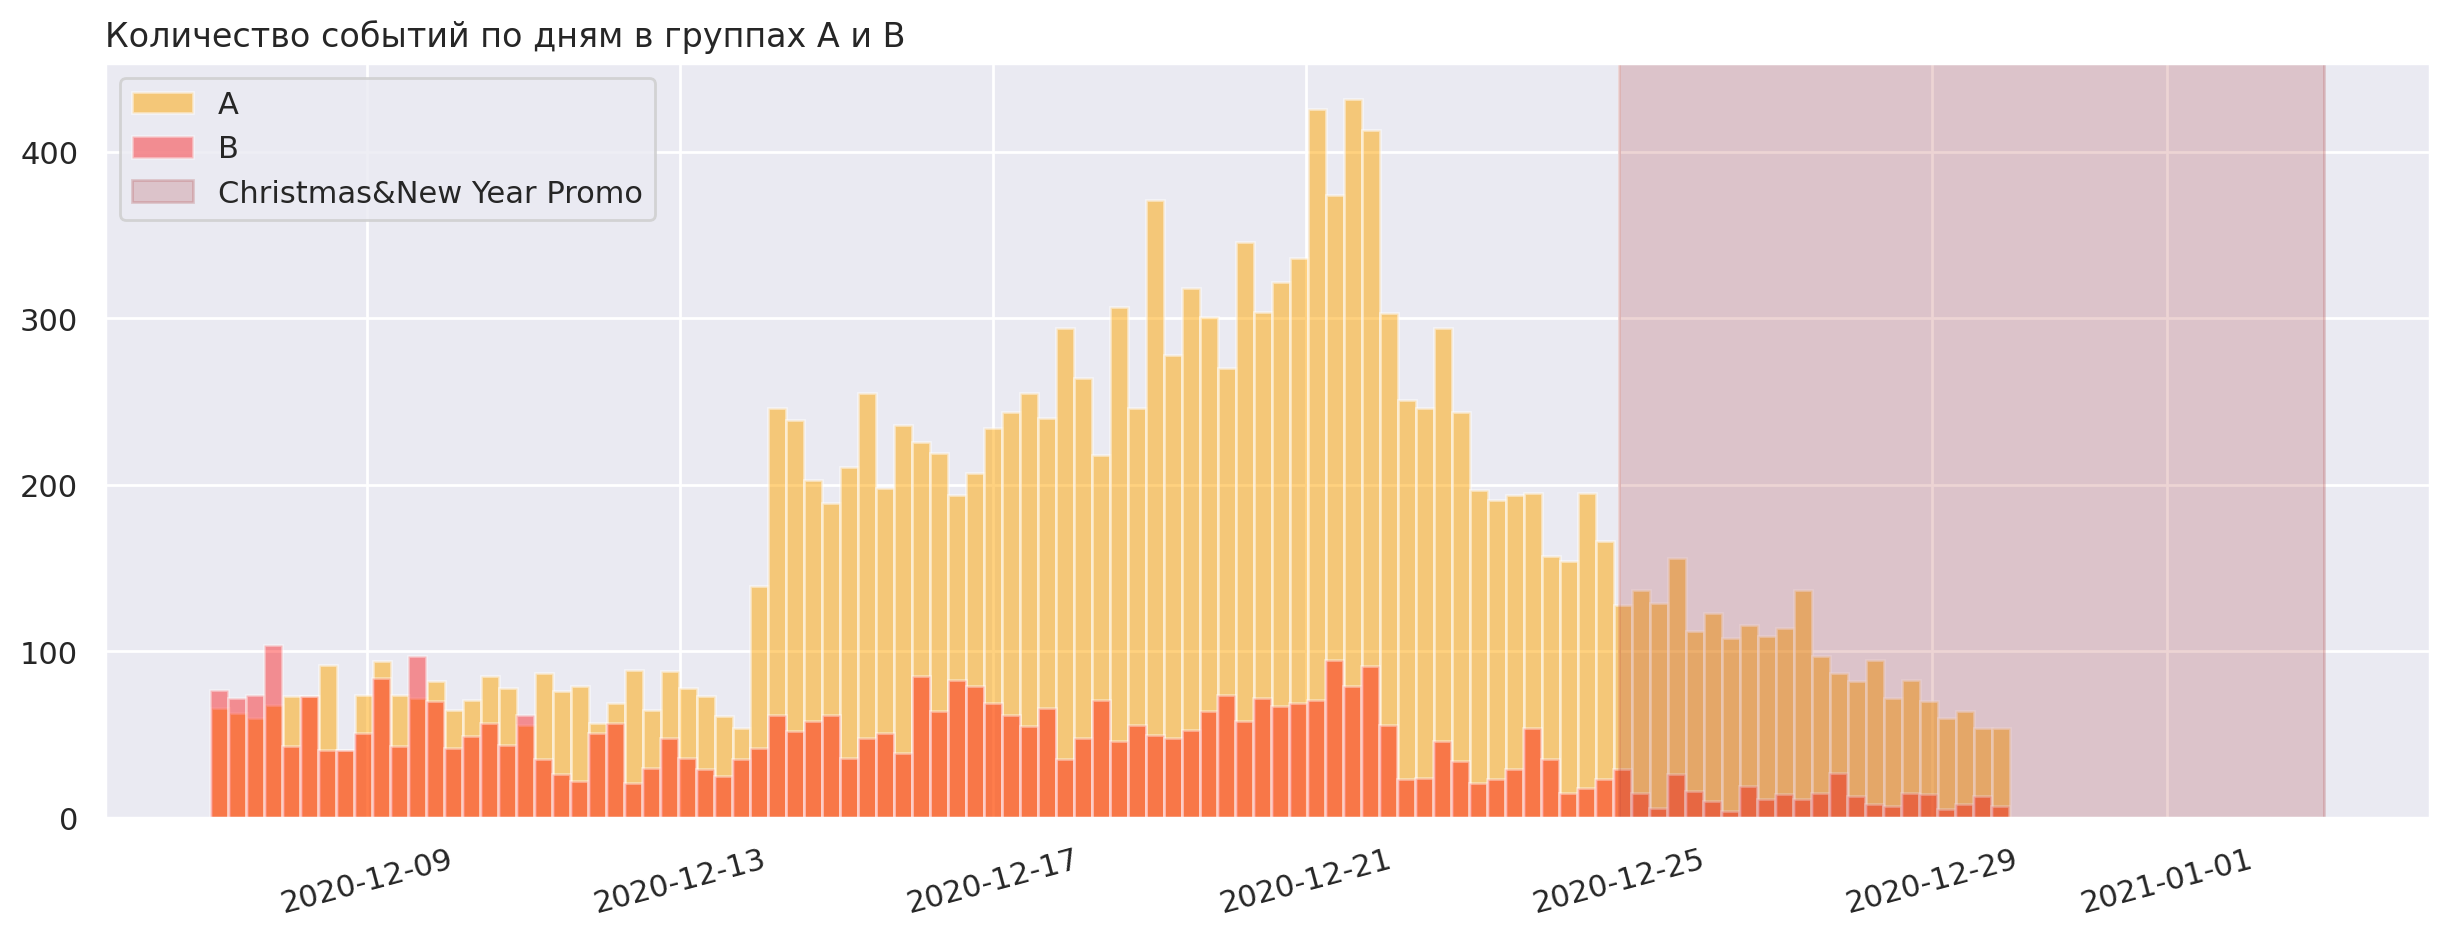

In [168]:
#гистограмма событий по дате в разрезе тестовых групп:

plt.title('Количество событий по дням в группах А и В', loc='Left')
events_new[events_new['group'] == 'A']['event_dt'].hist(bins = 100,  figsize=(15, 5), color = 'orange', label = 'A', alpha=.5)
events_new[events_new['group'] == 'B']['event_dt'].hist(bins = 100,  figsize=(15, 5), color = 'red', label = 'B', alpha=.4)
plt.axvspan('2020-12-25', '2021-01-03', color='brown', alpha=.2, label = 'Christmas&New Year Promo')
plt.xticks(rotation=15)
plt.legend()
plt.show()

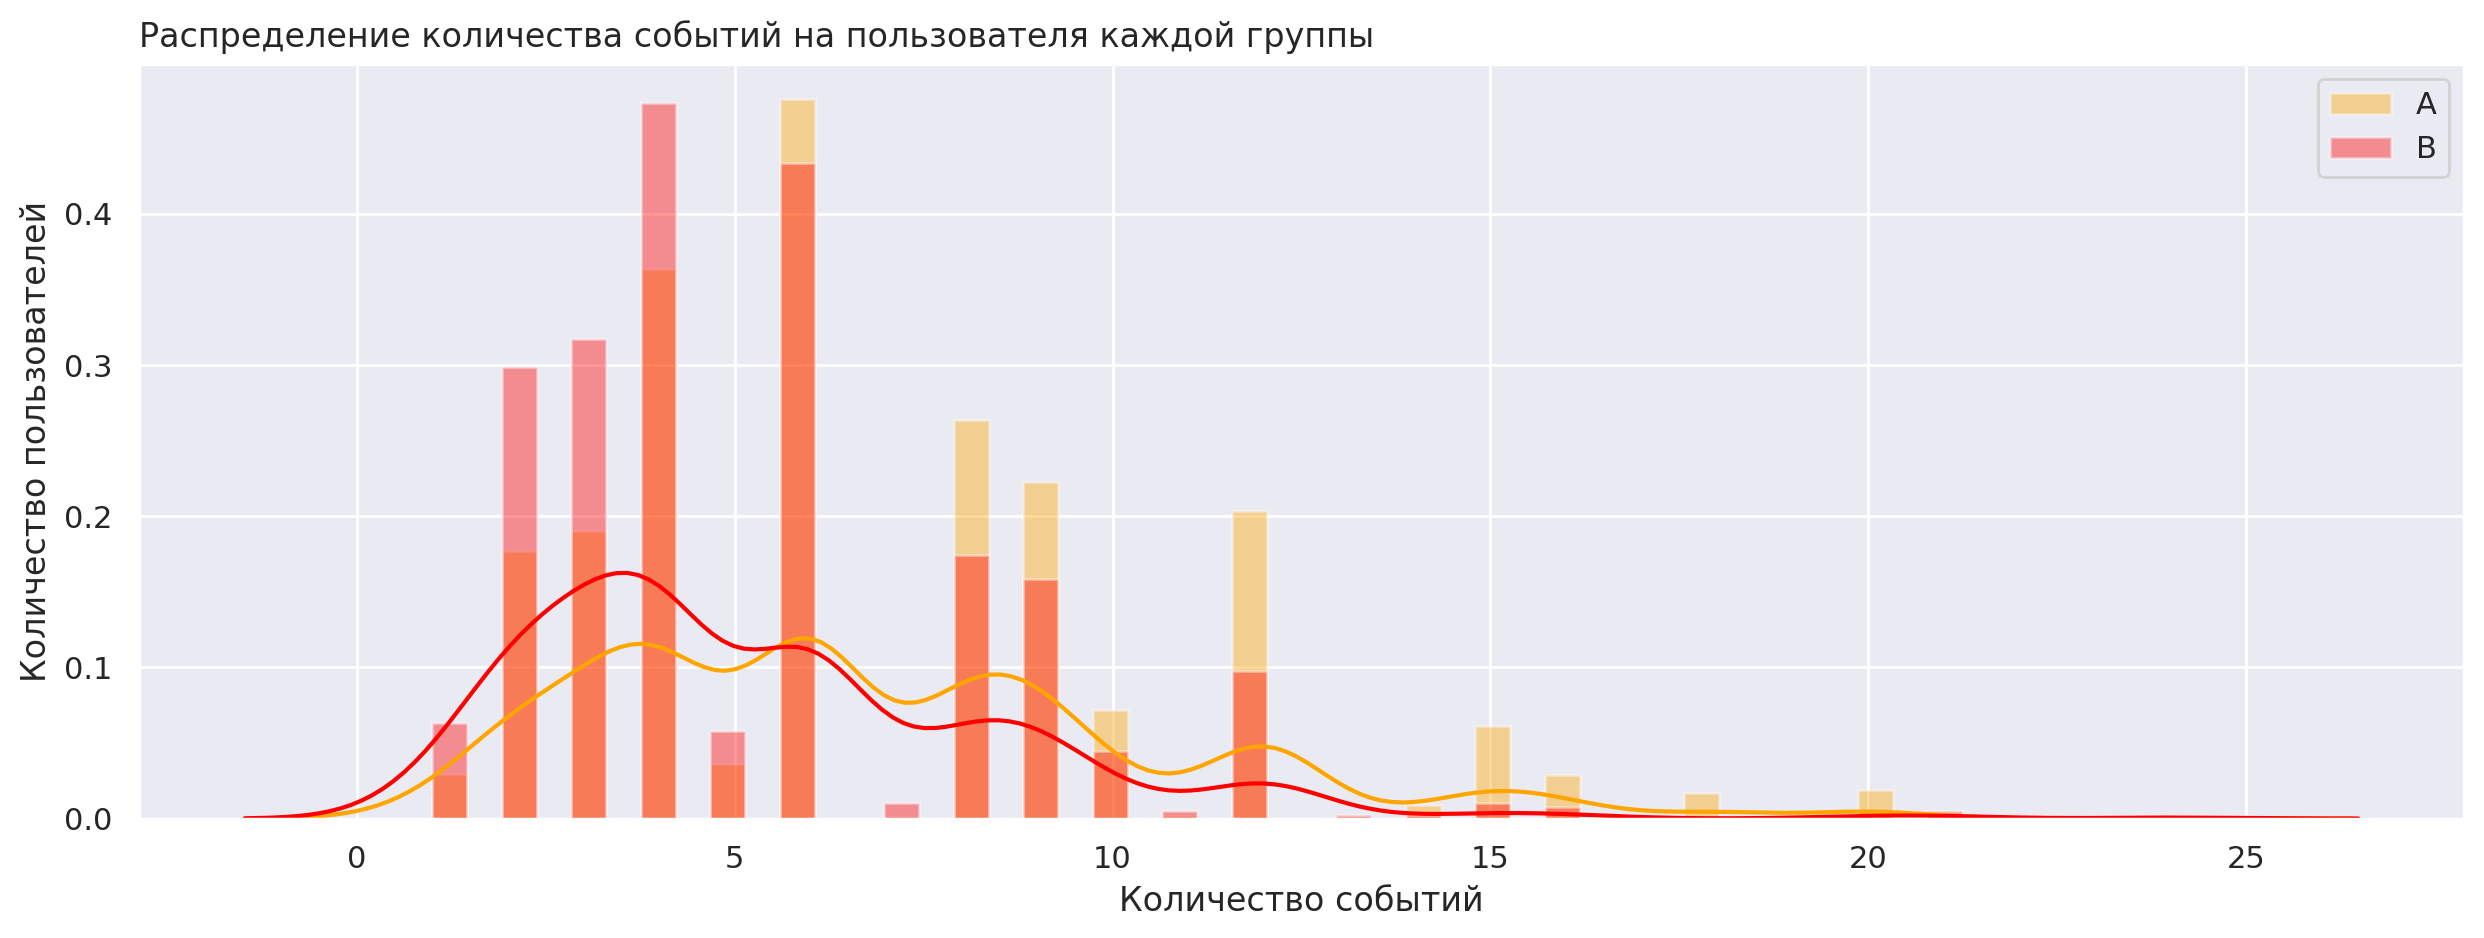

In [169]:
# посмотрим, сколько событий в среднем приходится на пользователя каждой группы:
events_user_a = events_new[events_new['group'] == 'A'].groupby('user_id').agg(event_count = ('event_name', 'count')).reset_index()
events_user_b = events_new[events_new['group'] == 'B'].groupby('user_id').agg(event_count = ('event_name', 'count')).reset_index()

plt.figure(figsize=(15, 5))
plt.title('Распределение количества событий на пользователя каждой группы', loc='left')
sns.distplot(events_user_a['event_count'], bins=50, label='A', color='orange')
sns.distplot(events_user_b['event_count'], bins=50, label='B', color='red')
plt.xlabel('Количество событий')                  
plt.ylabel('Количество пользователей')     
plt.legend()
plt.show()

In [170]:
events_user_b.describe()

,event_count
count,822.00
mean,5.34
std,3.17
min,1.00
25%,3.00
50%,4.00
75%,6.00
max,24.00


Количество событий на пользователя в группе В немного ниже, но не сильно.

In [171]:
funnel_group = (events_new.
          groupby(['event_name', 'group']).
          agg({'user_id': 'nunique'}).
          reset_index().
          rename(columns={'user_id' : 'total_users'}).
          sort_values(by=['group','total_users'], ascending=False))


funnel_group

,event_name,group,total_users
1,login,B,821
5,product_page,B,459
7,purchase,B,226
3,product_cart,B,225
0,login,A,2422
4,product_page,A,1571
6,purchase,A,773
2,product_cart,A,728


Чтобы графики отображались верно, здесь тоже добавим колонку с последовательность и отсортируем события по ней.

In [172]:
funnel_group['n'] = [1, 2, 4, 3, 5, 6, 8, 7]
funnel_group = funnel_group.sort_values(by='n')
funnel_group

,event_name,group,total_users,n
1,login,B,821,1
5,product_page,B,459,2
3,product_cart,B,225,3
7,purchase,B,226,4
0,login,A,2422,5
4,product_page,A,1571,6
2,product_cart,A,728,7
6,purchase,A,773,8


In [173]:
fig = go.Figure()

fig.add_trace(go.Funnel(name = 'A',
   y = funnel_group.query('group == "A"')['event_name'],
   x = funnel_group.query('group == "A"')['total_users'],
   opacity = 0.6,
   textposition = 'inside',
   textinfo = 'value + percent previous',
   marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal"]}))
                       

fig.add_trace(go.Funnel(name = 'B',
    y = funnel_group.query('group == "B"')['event_name'],
    x = funnel_group.query('group == "B"')['total_users'],
    opacity = 0.6,
    textposition = 'inside',
    textinfo = 'value + percent previous',
    marker = {"color": ["orange", "yellow", "brown", "red"]}))
                        
fig.update_layout(title_text='Воронка событий в разрезе тестовых групп')
fig.show()

В разрезе групп мы так же видим, что наибольшее количество пользователей  теряется после первого шага (около 35% у группы А и 44% у группы В). Относительная разница конверсии в группе В к таковой в группе А = 56/65 - 1 = 13% ( в меньшую сторону).
30% от первоначального количества пользователей группы А успешно оплачивают товары из корзины. У пользователей группы В это значение меньше: 28%.   

По-прежнему используется обходной путь: оплата может проходить минуя шаг Корзина, т.е. не прослеживается ожидаемая последовательность событий Авторизация -> Просмотр товара -> Просмотр корзины -> Покупка.

## Оценка результатов A/B-тестирования, проверка статистических гипотез

Определим, есть ли статистически значимая разница между долями прошедших по воронке пользователей в группах А и В.

Перед проверкой гипотезы о равенстве долей очистим данные от выбросов - исключим пользователей с большим числом событий. Посчитаем 95-й, 98-й и 99-й перцентили  и выберим границу для определения аномалий.

In [174]:
print(np.percentile(events_new.groupby('user_id').agg(events=('event_name', 'count')), [95, 98, 99])) 

[14. 16. 18.]


Исключаем пользователей с числом событий более 16.

In [175]:
events_count = events_new.groupby('user_id').agg(events=('event_name', 'count')).reset_index()
spenders = events_count.query('events > 16')

print('Пользователей с повышенным количеством действий -  %s человек' % len(spenders))
print('Пользователей до удаления выбросов - %s человек'% len(events_new['user_id'].unique()))
events_new = events_new[~events_new['user_id'].isin(spenders['user_id'])]
print('Пользователей после удаления выбросов - %s' % len(events_new['user_id'].unique()))


Пользователей с повышенным количеством действий -  47 человек
Пользователей до удаления выбросов - 3244 человек
Пользователей после удаления выбросов - 3197


Cогласно предложенному процессу, нам нужно будет сопоставить доли уникальных пользователей, т.е. проверить три гипотезы о равенстве долей в группах А и В при конверсии в:
*    просмотре карточек товаров (product_page)
*    просмотре корзины (product_cart)
*    покупке (purchase)
    
    
Всего у нас 3 вида событий, следовательно для всех тестов мы вводим поправку Бонферрони `bonferroni_alpha = alpha / 3`, чтобы застраховать себя от ложного результата.

<p>Введем основную и альтернативные гипотезы для всех попарных сравнений:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{доли уникальных посетителей, побывавших на этапе воронки, одинаковы}\\
   H_1 :\text{доли уникальных посетителей, побывавших на этапе воронки, отличаются}
 \end{cases}
\end{equation*}$

In [176]:
def z_test(df1, df2, event, alpha, n):
    '''    
Функция принимает на вход два датафрейма с логами и по заданному событию попарно проверяет 
есть ли статистически значимая разница между долями пользователей, совершивших его в группе 1 и группе 2.

Входные параметры:
    - df1, df2 - датафреймы с логами
    - event - событие
    - alpha - критический уровень статистической значимости
    - n - поправка Боннферони для критического уровня статистической значимости
    '''    
    
    # критический уровень статистической значимости c поправкой Бонферрони
    bonferroni_alpha = alpha / n
 
    # число пользователей в группе 1 и группе 2:
    n_users = np.array([df1['user_id'].nunique(), 
                        df2['user_id'].nunique()])

    # число пользователей, совершивших событие в группе 1 и группе 2
    success = np.array([df1[df1['event_name'] == event]['user_id'].nunique(), 
                        df2[df2['event_name'] == event]['user_id'].nunique()])

    # пропорции успехов в группах:
    p1 = success[0]/n_users[0]
    p2 = success[1]/n_users[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (n_users[0] + n_users[1])
    
    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference /  np.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2   #тест двусторонний, удваиваем результат
    
    print('Событие:', event)
    print('p-значение: ', p_value)

    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [177]:
for event in ['product_page', 'product_cart', 'purchase']:
    z_test(events_new[events_new['group'] == 'A'], events_new[events_new['group'] == 'B'], event,.05, 3)
    print()

Событие: product_page
p-значение:  1.043046471571607e-05
Отвергаем нулевую гипотезу: между долями есть разница

Событие: product_cart
p-значение:  0.24057574359840972
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: purchase
p-значение:  0.0314256198772922
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



## Вывод и рекомндации

Тест был проведён с нарушениями:

*    После набора пользователей, но до остановки теста, в период с 25.12.2020 по 03.01.2021 в EU проводилась акция "Christmas&New Year Promo".
*    В выгрузке нет данных о событиях с 31.12.2020 по 04.01.2021 (время остановки теста). Не хватает информации за 5 дней.
*    Параллельно с нашим тестом шёл другой. После дополнительной проверки мы пришли к выводу, что это не повлияло на результаты нашего тестирования, а пользователи, которые параллельно участвовали в двух экпериментах, не исключались из исследования. 
*    Количество участников в группах А и В сильно различается (3385 и 2533, соответственно).
*    Почти половина пользователей теста не совершили ни одного действия в системе. Активных пользователей в группе А оказалось почти в 3 раза больше, чем в группе В (2422 против 822)
*    Так же, проведение эксперимента совпало с сезонным спросом - покупкой подарков на Рождество и Новый год.

Все вышеперечисленные факторы могут исказить результаты тестирования. Для чистоты эксперимента необходимо доработать механизм формирования тестовых групп и запустить тест заново, предварительно сверившись с календарём маркетинговых акций.


В ходе исследовательского анализа имеющихся данных установлены следующие особенности: в системе не прослеживается ожидаемая последовательность событий Авторизация -> Просмотр товара -> Просмотр корзины -> Покупка.

Результаты проверки гипотезы о равенстве долей уникальных пользователей свидетельствуют:

* доли уникальных посетителей, побывавших на этапе воронки Просмотр товара, отличаются.  Количество потерянных с предыдущего шага (Авторизация) пользователей - 35% у группы А и 44% у группы В. Группа В  проигрывает. 
* отсутствует существенная  разница  в долях уникальных пользователей между группами А и В при конверсии в Просмотр корзины и в Покупку.

Таким образом, по имеющимся данным, новая рекомендательная система целевые метрики **не улучшила**.